E13. 인공지능으로 세상에 없던 새로운 패션 만들기
======

tf.keras 안에 있는 datasets인 fashion_mnist 데이터를 사용하여 생성 모델 중 하나인 DCGAN(Deep Convolutional Generative Adversarial Network) 만들어보기 

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


# 1. 데이터 전처리 

In [2]:
# 분류 문제에서와 달리, 각 이미지가 어떤 카테고리인지 나타내주는 라벨이 필요 없습니다.
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


- Fashion MNIST는 28x28 픽셀의 이미지로, 각 픽셀은 0~255 사이의 정숫값을 가집니다. 

In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


- 이번 프로젝트에서는 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로,     
    중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠줍니다.



In [5]:
train_x.shape

(60000, 28, 28)

In [6]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

- Fashion MNIST 데이터는 흑백 이미지이므로, 채널 값은 1이죠. 따라서 데이터셋의 shape 마지막에 1을 추가해 줍니다.

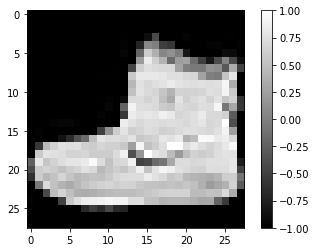

In [7]:
# 데이터 확인
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

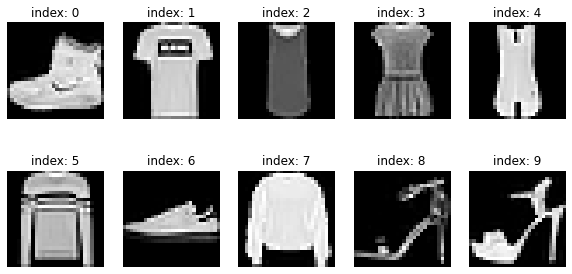

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

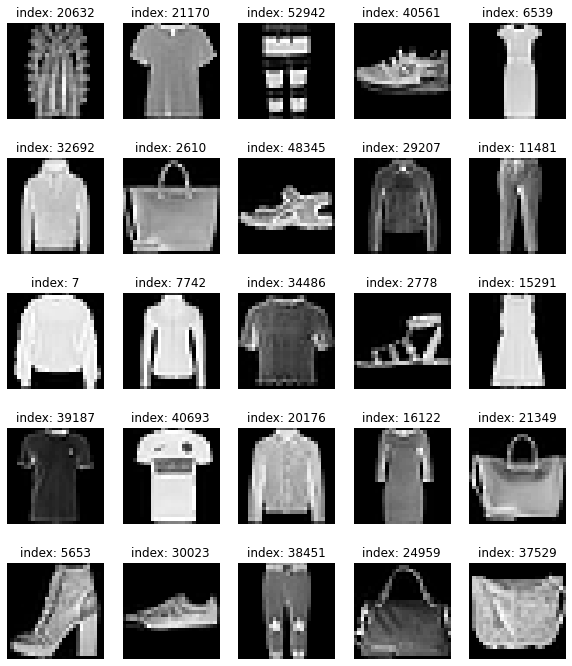

In [9]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

- BUFFER_SIZE은 전체 데이터를 섞기 위해 60,000으로 설정합니다. shuffle() 함수가 데이터셋을 잘 섞어서 모델에 넣어줄 것입니다.
- BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양입니다.    
    너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적이고, 한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습을 진행합니다. 이러한 방식을 미니 배치 학습 이라고 합니다.

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

-  train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다.     
    데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.

# 2. DCGAN(Deep Convolutional GAN) 모델링

- 생성자(Generator)는 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성해 냅니다. 즉, 무에서 유를 창조하는 것과 같은 역할을 합니다.
- 판별자(Discriminator)는 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real 인지, Fake 인지에 대한 판단 정도를 실숫값으로 출력합니다.

## (1) 생성자 구현하기

In [12]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

- make_generator_model이라는 함수를 만들어서 언제든 생성자를 생성할 수 있도록 했습니다.
    

- 함수 내부에서는 먼저 tf.keras.Sequential()로 모델을 시작한 후 레이어를 차곡차곡 쌓아줍니다.

- 여기에서 가장 중요한 레이어는 바로 Conv2DTranspose 레이어입니다.      
    Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층입니다.      
    이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (7, 7, 256) → (14, 14, 64) → (28, 28, 1) 순으로 이미지를 키워나갑니다.     
    여기서 최종 사이즈인 (28, 28, 1)은 우리가 준비했던 데이터셋과 형상이 동일합니다.
- 레이어의 사이사이에 특정 층들이 반복되는 것을 확인할 수 있는데, 
    - BatchNormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜줍니다. 
    - 또한 중간층들의 활성화 함수는 모두 LeakyReLU를 사용하였습니다.     
        다만 마지막 층에는 활성화 함수로 tanh를 사용하는데, 이는 우리가 -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함입니다.

In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [14]:
# 랜덤 노이즈 생성
noise = tf.random.normal([1, 100])

- tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있습니다.

In [15]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

- 지금은 학습하는 중이 아니니 training=False를 설정해 주어야 합니다! Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 training=False을 주어야 올바른 결과를 얻을 수 있습니다.
     
- [1, 28, 28, 1] 사이즈의 이미지가 잘 생성되었군요!    
    첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (28, 28, 1) 사이즈 이미지가 생성되었다는 뜻을 가집니다.

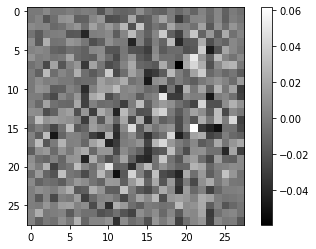

In [16]:
# 이미지 시각화 
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

- matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서 (28, 28) shape의 이미지를 꺼낼 수 있도록 해야 합니다.

## (2) 판별자 구현하기

판별자는 앞서 알아봤듯 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야 합니다.     
그렇다면 입력은 (28, 28, 1) 크기의 이미지가, 출력은 단 하나의 숫자(진짜라고 판단하는 정도)가 될 것입니다.

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

- Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나갑니다.    
    첫 번째 Conv2D 층에서 입력된 [28, 28, 1] 사이즈의 이미지는 다음 층을 거치며 (28, 28, 1) → (14, 14, 64) → (7, 7, 128)까지 줄어들게 됩니다.

- 마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환합니다.      
    이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 합니다. 
    
- 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 됩니다.

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [19]:
# 아까 만들었던 랜덤 노이즈 이미지 넣어보기
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00257775]], dtype=float32)>

- 텐서플로우의 텐서 형태로 출력이 되었습니다. 이 값 또한 아직은 아무런 의미가 없는 값일 것입니다.

# 3. 손실함수와 최적화 함수

## (1) 손실함수(loss function)

GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용합니다.
- 교차 엔트로피는 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰입니다. 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것입니다.


손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는 다음과 같겠죠. 
- 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
- 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것     

결국 생성자든 구분자든, 결국 손실함수에 들어가는 값은 모두 판별자의 판별값이 되겠네요!

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

이제 cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용합니다.

- fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
- real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

fake_output과 real_output을 각각 1 또는 0에 비교를 해야 하는데, 어떻게 비교할 수 있을까요?

- 바로 tf.ones_like()와 tf.zeros_like() 함수를 활용하면 됩니다.    
    이 함수들은 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용합니다.

### generator_loss

generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.    
즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss

반면, discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 되겠죠!    
    
최종 discriminator_loss 값은 이 둘을 더한 값입니다.

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy

한편, 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요합니다. 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용합니다.    
      
- 만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까요? 그렇지 않습니다.      
    이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻입니다. 
- 그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻입니다.

In [25]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

- tf.math.greater_equal(real_output, tf.constant(\[0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별 - >> tf.Tensor([False, False, True, True])
- tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 - >> tf.Tensor([0.0, 0.0, 1.0, 1.0])
- tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - >> 0.5

## (2) 최적화 함수(optimizer)

tf.keras.optimizers 안에 있는 Adam 최적화 기법 을 활용해 보겠습니다.

- 중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천합니다.
- 또한, 중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점입니다.

In [26]:
# learning rate = 0.0001
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

또한, 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것입니다.

- 샘플은 한 번에 16장을 생성하도록 하겠습니다.
- 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.
- 즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 하겠습니다.

In [27]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 4. 훈련과정 설계

하나의 미니 배치 당 진행할 train_step 함수를 먼저 만들어야 합니다.
- 텐서플로우 2.0 이후부터는 1.x의 이전 버전과 다르게, session을 사용하지 않습니다.     
    대신, 학습시킬 훈련 함수 위에 @tf.function 이라는 데코레이터를 붙여서 사용합니다.      
    이 데코레이터는 우리가 직접 session을 열어서 학습했다가, 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해서 더욱 편리하게 학습시킬 수 있게 해줍니다.
    
- @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환됩니다. 알아두면 향후 Tensorflow 모델 구현에 매우 편리하게 사용할 수 있을 것 같습니다.

In [30]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

train_step 함수를 하나하나 뜯어보면 다음과 같습니다.

- (1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
- (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
- (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
- (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
- (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
- (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
- (7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
- (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
- (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴
    
이러한 일련의 과정을 통해 한 번의 train_step이 끝나게 됩니다.

In [31]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/Exploration/E13/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

이렇게 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만들어 봅니다.     
아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있습니다.
    
- model이 16개의 seed가 들어있는 sample_seeds를 입력받아서 만들어낸 prediction을 matplotlib으로 시각화해주는 과정이 담겨 있습니다. 
- plt에 저장되어 보이는 이미지를 plt.savefig로 간단히 파일로 저장합니다.

In [37]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/Exploration/E13/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

학습 과정을 체크하기 위해 시각화해 보아야 할 중요한 것으로 loss와 accuracy 그래프를 빼놓을 수 없겠습니다.     
GAN의 학습 과정은 지도학습 모델보다 까다로운데, 이것은 두 모델이 서로의 학습 과정에 영향을 주고받기 때문입니다. 
     
- train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 입니다. 예를 들어 생성자의 loss의 history는 history\['gen_loss']로 접근할 수 있는 list로 관리할 예정입니다.

다음은 정기적으로 모델을 저장하기 위한 checkpoint를 만들어줍니다.

- tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해 주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있습니다.
- checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장합니다. 정확히는 생성자와 판별자가 학습한 모델 가중치를 저장하는 것이죠. 게임의 체크포인트처럼 우리의 학습 환경과 학습한 내용을 저장해 둡니다.
- checkpoint 모델을 저장하기 위해 작업환경 내에 training_checkpoints 라는 디렉토리를 사용합니다.

In [38]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/Exploration/E13/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 5. 학습 시키기

지금까지 한 단계를 학습하는 train_step, 샘플 이미지를 생성하고 저장하기 위한 generate_and_save_images(), 학습 과정을 시각화하는 draw_train_history(), 그리고 모델까지 저장하기 위한 checkpoint까지 모두 준비가 되었으니 이것들을 한곳에 합치기만 하면 됩니다.

In [39]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

여기서부터는 정말 별로 특별한 것이 없습니다. 우리가 생성된 샘플을 시각화하거나 원하는 시간을 출력하는 것뿐이니까요.    
출력하고자 하는 print문과 몇 번마다 출력하는지에 대한 구문을 원하는 대로 수정해서 마음에 드는 형태로 확인해 보세요!

이제 다음과 같이 train() 함수를 실행시키면 드디어 모델이 학습해 나가면서 만들어내는 결과물을 실시간으로 확인할 수 있습니다!

In [40]:
# 모델을 저장하는 간격을 담당하는 save_every
# 전체 학습 에포크를 결정하는 EPOCHS 파라미터도 설정
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

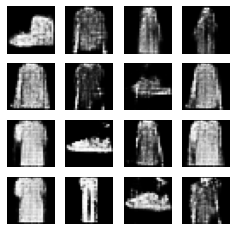

Time for training : 1484 sec


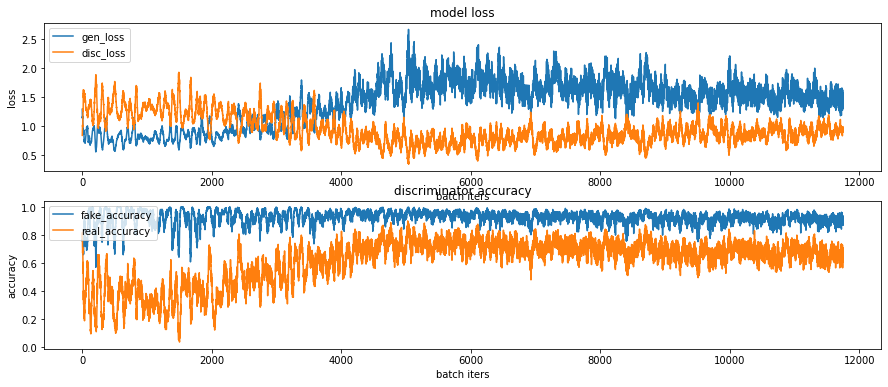

CPU times: user 9min 27s, sys: 20.1 s, total: 9min 47s
Wall time: 24min 45s


In [41]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/Exploration/E13/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

만약 생성자가 만든 Fake Image에 대한 판별자의 Accuracy(fake_accuracy)가 계속 1에 가깝게 유지되고 있다면, 생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 뜻입니다.
     
보다 나은 결과물을 만들기 위해서는 더욱 많은 epoch으로 학습을 시켜야 합니다. 결과물이 아직 흐릿하다면 더욱 많은 학습을 시켜보세요!
과연 생성 모델이 이전에는 없던 새로운 디자인의 패션을 만들어내는 것을 확인할 수 있을 거예요..! (물론 시간은 그와 비례하게 늘어나겠죠..?)
    
어쩌면 단순히 학습 수행 시간만 늘리는 것보다, 모델 구조나 학습 방법을 바꾸어 봐야 할 수도 있습니다. 그래프를 유심히 보면서 학습 결과가 더 이상 개선되고 있지 않은지 여부를 지속적으로 살펴봅시다.

## 학습과정 시각화하기

학습이 끝난 후 우리가 생성했던 샘플 이미지들을 합쳐 GIF 파일, 일명 움짤로 만들어 보겠습니다. 더욱 생생한 학습 진행 과정을 확인해 볼 수 있을 테니까요!
    
- GIF 파일은 우리가 오래전에 import 해놓았던 imageio 라이브러리를 활용해 만들 수 있습니다.
- imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식입니다.
- 아래 코드가 무사히 실행되면, fasion_mnist_dcgan.gif 파일이 저장되어 있는 것을 확인할 수 있을 겁니다!

In [42]:
anim_file = os.getenv('HOME')+'/aiffel/Exploration/E13/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/Exploration/E13/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/Exploration/E13/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1289317 Nov 16 16:04 /aiffel/aiffel/Exploration/E13/fashion/fashion_mnist_dcgan.gif


~/aiffel/Exploration/E13/fashion/ 폴더 경로에 fashion_mnist_dcgan.gif를 클릭하시면 생성자가 만들어내는 이미지의 품질이 점점 개선되어 가는 과정을 한눈에 볼 수 있습니다.
    
이상으로 GAN을 이용하여 새로운 패션을 생성해 내는 AI 모델에 대하여 살펴보았습니다. 